In [ ]:
# import libraries
import os

from sirf.Utilities import examples_data_path

import sirf.Reg as reg
import sirf.STIR as pet
from cil.optimisation.algorithms import PDHG, SPDHG
from cil.optimisation.functions import KullbackLeibler, BlockFunction, IndicatorBox, MixedL21Norm
from cil.optimisation.operators import CompositionOperator, BlockOperator, LinearOperator
from cil.plugins.ccpi_regularisation.functions import FGP_TV
from cil.utilities.display import show2D
from ccpi.filters import regularisers

import numpy as np

In [1]:
# Acquisition data stored in memory
pet.AcquisitionData.set_storage_scheme('memory')
pet.set_verbosity(0)

In [2]:
# set path to use the NEMA phantom
data_path = os.path.join( examples_data_path('PET') , 'mMR' )
os.chdir(data_path)

# sinogram data
template_acq_data = pet.AcquisitionData('Siemens_mMR', span=11, max_ring_diff=15, view_mash_factor=1)
acq_data = pet.AcquisitionData('sino_f1g1d0b0.hs')

# random counts
rand_arr = pet.AcquisitionData('sino_randoms_f1g1d0b0.hs').as_array()
rand = acq_data * 0
rand.fill(rand_arr)

In [3]:
# attenuaion
attns = pet.ImageData('mu_map.hv')
asm_norm = pet.AcquisitionSensitivityModel('norm.n.hdr')

# Setup image geometry
image = acq_data.create_uniform_image(0., (127, 220, 220))
image.initialise(dim=(127, 220, 220), vsize=(2.03125, 1.7080754, 1.7080754))

def get_asm_attn(sino, attn, acq_model):
    """Get attn ASM from sino, attn image and acq model."""
    asm_attn = pet.AcquisitionSensitivityModel(attn, acq_model)
    # temporary fix pending attenuation offset fix in STIR:
    # converting attenuation into 'bin efficiency'
    asm_attn.set_up(sino)
    bin_eff = pet.AcquisitionData(sino)
    bin_eff.fill(1.0)
    asm_attn.unnormalise(bin_eff)
    asm_attn = pet.AcquisitionSensitivityModel(bin_eff)
    return asm_attn

# set up the acquisition model
am = pet.AcquisitionModelUsingRayTracingMatrix()

# ASM norm already there
asm_attn = get_asm_attn(acq_data,attns,am)

# Get ASM dependent on attn and/or norm
asm = pet.AcquisitionSensitivityModel(asm_norm, asm_attn)
am.set_acquisition_sensitivity(asm)
am.set_background_term(rand)
am.set_up(acq_data, image)

Reading manufacturer PET normalisation file from norm.n.hdr


In [6]:
# Get linear acquisition model
K = am.get_linear_acquisition_model()

In [8]:
K = am.get_linear_acquisition_model()
K.acq_templ=acq_data
K.img_templ=image

To accelerate the reconstruction, we use diagonal preconditioning to compute $\sigma$ and $\tau$ based on the operator K. See [here](https://ieeexplore.ieee.org/document/6126441) for more information.

In [13]:
tmp_sigma = K.direct(K.domain_geometry().allocate(1.)).power(-1)
tmp_tau = K.adjoint(K.range_geometry().allocate(1.)).power(-1)

tmp_tau_np = tmp_tau.as_array()
tmp_tau_np[tmp_tau_np==np.inf]=1e-5
tau = tmp_tau*0.
tau.fill(tmp_tau_np)

tmp_sigma_np = tmp_sigma.as_array()
tmp_sigma_np[tmp_sigma_np==np.inf]=1e-5
sigma = tmp_sigma*0.
sigma.fill(tmp_sigma_np)

The implementation of `FGP_TV` does not accept $\tau$ as a `numpy` array. Hence, we change its `proximal` method to a `precond_proximal` method. 

In [23]:
def precond_proximal(self,x,tau, out=None):
        in_arr = np.asarray(x.as_array()/tau.as_array(), dtype=np.float32, order='C')      
        res , info = regularisers.FGP_TV(\
              in_arr,\
              self.alpha,\
              self.max_iteration,\
              self.tolerance,\
              self.methodTV,\
              self.nonnegativity,\
              self.device)
        if out is not None:
            out.fill(res)
        else:
            out = x.copy()
            out.fill(res)
        out *= tau    
        return out    
    
FGP_TV.proximal = precond_proximal

Next, we define the fidelity term **KullbackLeibler** based on the acqusition data and random events. For the regularisation term we use the **FGP_TV** function class from the [CCPi-RegTk](https://github.com/vais-ral/CCPi-Regularisation-Toolkit).

In [38]:
alpha = 13.0
F = KullbackLeibler(b = acq_data, eta = rand)
G = alpha*FGP_TV(max_iteration=100, device='gpu' )

In [42]:
max_iterations = 100 # Use 500 to match the results in the paper. 

In [44]:
# Setup and run PDHG
pdhg = PDHG(f = F, g = G, operator=K, sigma = sigma, tau = tau,
            max_iteration = max_iterations, update_objective_interval = 100, use_axpby=False)
pdhg.run(verbose = 2)

PDHG setting up
PDHG configured
     Iter   Max Iter     Time/Iter        Primal          Dual     Primal-Dual
                               [s]     Objective     Objective             Gap
        0        100         0.000    3.27847e+07  -0.00000e+00    3.27847e+07
      100        100        21.422    8.87311e+06   3.63217e+06    5.24095e+06
----------------------------------------------------------------------------
      100        100        21.422    8.87311e+06   3.63217e+06    5.24095e+06
Stop criterion has been reached.



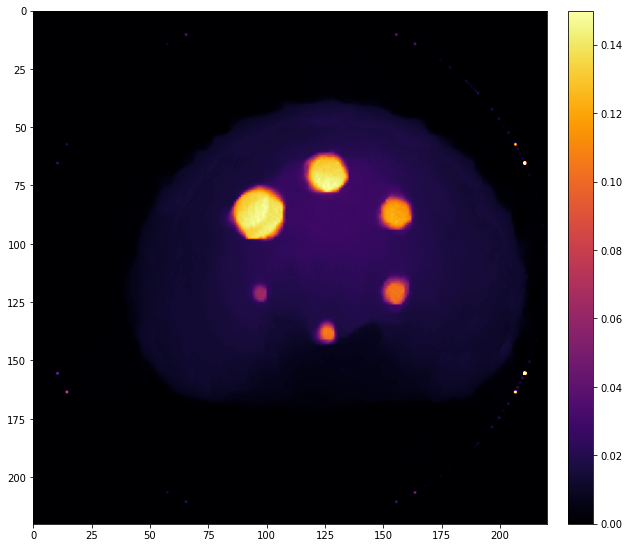

In [45]:
# after 100 iterations
show2D(pdhg.solution.as_array()[72,:,:], cmap="inferno", origin="upper", fix_range=(0,0.15))

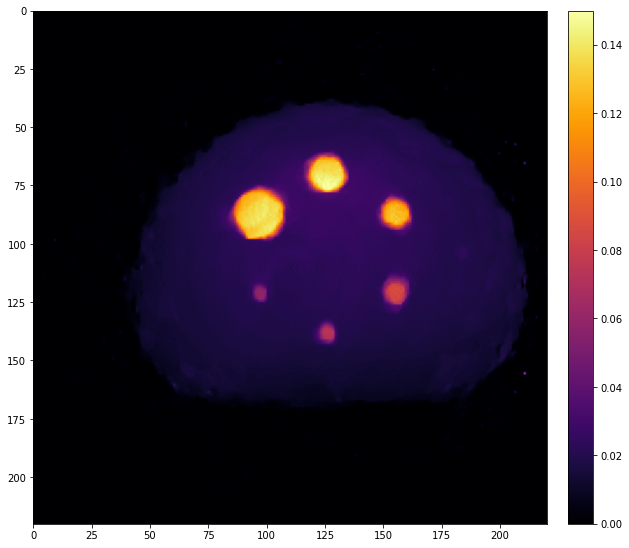

In [37]:
# after 500 iterations
show2D(pdhg.solution.as_array()[72,:,:], cmap="inferno", origin="upper", fix_range=(0,0.15))